In [ ]:
!pkill -f ngrok

In [ ]:
! pip install dash
! pip install pyngrok
!pip install --upgrade diffusers accelerate transformers DeepCache xformers peft openai gradio translate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.1/375.1 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9

In [ ]:
import re, openai, accelerate, transformers, torch, xformers, peft, gc, matplotlib.pyplot as plt
import gradio as gr
from translate import Translator
from diffusers import DiffusionPipeline, AutoencoderTiny, AutoPipelineForText2Image, LCMScheduler, AutoPipelineForImage2Image
from diffusers.utils import make_image_grid, load_image
from huggingface_hub import notebook_login
from IPython.display import display, Image
from PIL import Image
from IPython.display import clear_output

import re




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

'''
from IPython.display import Image

# 檔案路徑
image_path = '/content/drive/MyDrive/國泰產險/產險_LLM讀書會/assets/KV.jpeg'

# 顯示照片
Image(image_path)
'''

In [ ]:
openai.api_key = 'test'
prompts = {
    "character": "根據姓名 {user_name}，生成一個武俠角色，包括性别、年齡、外貌特徵、性格、擅長武器、武學和出身背景，不超過兩百字，請保持句子完整。",
    "clan": "基於該武俠角色，生成兩個適合他的武俠幫派，並簡單介绍兩個幫派，介紹字詞各別都不要超過一百字，請保持句子完整。",
    "martial_arts": "基於所選擇的幫派 {selected_clan}，生成兩個適合該幫派的武功，並簡單描述每個武功的特點，描述字詞各別都不要超過一百字，請保持句子完整。",
    # "main_scenario": "基於所設定的武俠角色的名字還有資訊、幫派、武功、出身背景，生成一個符合這武俠角色的簡短主情境，請勿超過一百字，請保持句子完整。",
    # "scenario_directions": "基於該武俠角色、幫派和武功，延續主情境，生成兩個符合這武俠角色的後續剪短情境選項選擇，生成的簡短情境分別命名為選項一及選項二，請保持在一百字內。",
    # "conclusion": "根據以下武俠角色、幫派、武功和情境選擇，生成符合故事情節的結尾。"
}

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
adapter_id = "latent-consistency/lcm-lora-sdxl"
vae_id = "sayakpaul/taesd-diffusers"

pipe = DiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16, # TensorFloat-16
    variant="fp16").to("cuda")

pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
pipe.load_lora_weights("latent-consistency/lcm-lora-sdxl")


# 定义生成 prompt 响应的函数
def generate_prompt_response(prompt_key, **kwargs):
    if prompt_key == "main_scenario":
        prompt_text = (
            f"根據以下資訊，生成一個基於這個武俠角色的初始主情境：\n"
            f"角色信息：{kwargs['character_info']}\n"
            f"幫派：{kwargs['selected_clan']}\n"
            f"武功：{kwargs['selected_martial_arts']}\n"
            "這個主情境應該反映出該角色的背景和所屬幫派、所學武功，並作為後續故事的開始，且請勿超過200字，請保持句子完整。"
        )
    elif prompt_key == "scenario_directions":
        prompt_text = (
            f"你是一位武俠小說的作者，現在根據以下武侠的角色資訊及當前情境生成後續情境：\n"
            f"角色：{kwargs['character_info']}\n"
            f"幫派：{kwargs['selected_clan']}\n"
            f"武功：{kwargs['selected_martial_arts']}\n"
            f"當前情境：{kwargs['current_scenario']}\n"
            "請延續主情境，生成兩個符合這武俠角色的後續剪短情境選項選擇，生成的簡短情境分別命名為選項一及選項二，請保持在一百字內，請保持句子完整。"
        )
    elif prompt_key == "conclusion":
        prompt_text = (
            f"根據以下武俠角色、幫派、武功和情境選擇生成符合故事的結局：\n"
            f"角色信息：{kwargs['character_info']}\n"
            f"幫派：{kwargs['selected_clan']}\n"
            f"武功：{kwargs['selected_martial_arts']}\n"
            f"故事情境摘要：\n{kwargs['story_summary']}\n"
            "請生成一個符合以上內容的結局，讓故事有一個合乎邏輯的結尾，請保持句子完整。"
        )
    else:
        prompt_text = prompts[prompt_key].format(**kwargs)

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        max_tokens=500,
        temperature=0.6,
        stop=None,
        top_p=0.85,
        frequency_penalty=0.2,
        presence_penalty=0.3,
        messages=[{"role": "system", "content": prompt_text}]
    )
    return response.choices[0].message.content.strip()

def remove_english(text):
    # 使用正則表達式匹配並移除所有英文字符和符號
    cleaned_text = re.sub(r'[a-zA-Z]', '', text)
    return cleaned_text.strip()

def translate_to_english_translate_package(text):
    translator = Translator(to_lang="en", from_lang="zh-TW")
    translation = translator.translate(text)
    return translation

def generate_character(user_name):
    character_info = generate_prompt_response("character", user_name=user_name)
    character_info = remove_english(str(character_info))
    print(f"武俠角色生成: {character_info}")
    character_info_en = translate_to_english_translate_package(character_info)
    #print(character_info_en)
    print('---------------------------')

    prompt = character_info_en
    generator = torch.manual_seed(42)
    img = gen_img(prompt,4,generator,1)
    plt.imshow(img)  # 使用 PIL.Image 对象
    plt.axis('off')  # 隐藏坐标轴
    plt.show()  # 显示图像
    # plt.savefig("drive/MyDrive/LLM_Train/assets/武俠角色生成.png")
    return character_info, img

def generate_clans(character_info):
    clan_info = generate_prompt_response("clan")
    clan_info_en = translate_to_english_translate_package(clan_info)
    clan_info = remove_english(clan_info)
    print(f"幫派選項: {clan_info}")
    #print(clan_info_en)
    selected_clan = input("選擇一個幫派: ")
    return selected_clan

def generate_martial_arts(selected_clan):
    martial_arts_info = generate_prompt_response("martial_arts", selected_clan=selected_clan)
    martial_arts_info_en = translate_to_english_translate_package(martial_arts_info)
    martial_arts_info = remove_english(martial_arts_info)
    print(f"武功選項: {martial_arts_info}")
    #print(martial_arts_info_en)
    selected_martial_arts = input("選擇一個武功: ")
    return selected_martial_arts

def generate_wuxia_story(character_info, selected_clan, selected_martial_arts, img):
    # print("\n開始生成武俠故事...\n")
    conversation_history = []

    main_scenario = generate_prompt_response("main_scenario", character_info=character_info, selected_clan=selected_clan, selected_martial_arts=selected_martial_arts)
    main_scenario = remove_english(main_scenario)
    print(f"主情境: {main_scenario}")
    main_scenario_en = translate_to_english_translate_package(main_scenario)
    #print(main_scenario_en)
    prompt = main_scenario_en + character_info
    generator = torch.manual_seed(42)
    img = gen_img(prompt,4,generator,1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    # plt.savefig("drive/MyDrive/LLM_Train/assets/主情境.png")

    for i in range(10):
          # 清除當前單元格的輸出

        scenario_directions = generate_prompt_response("scenario_directions", character_info=character_info, selected_clan=selected_clan, selected_martial_arts=selected_martial_arts, current_scenario=main_scenario)
        scenario_directions = remove_english(scenario_directions)
        parts = scenario_directions.split("選項一：")
        option_one_part = parts[1].split("選項二：")
        option_one = option_one_part[0].strip()
        option_two = option_one_part[1].strip()

        print(f"選項一: {option_one}")
        print(f"選項二: {option_two}")

        choice = input("請選擇 '選項一' 或 '選項二': ")
        clear_output(wait=True)
        conversation_history.append({
            'main_scenario': main_scenario,
            'choice': choice
        })

        if choice == "選項一":
            main_scenario = option_one
        else:
            main_scenario = option_two

        print(f"\n新的主情境: {main_scenario}\n")

        new_main_scenario = main_scenario + character_info
        main_scenario_en = translate_to_english_translate_package(new_main_scenario)
        #print(main_scenario_en)

        prompt = main_scenario_en
        generator = torch.manual_seed(42)
        img = gen_img(prompt,4,generator,1)
        plt.imshow(img)  # 使用 PIL.Image 对象
        plt.axis('off')  # 隐藏坐标轴
        plt.show()  # 显示图像
        # plt.savefig("drive/MyDrive/LLM_Train/assets/後續情境.png")
    return conversation_history


def generate_conclusion(character_info, selected_clan, selected_martial_arts, conversation_history):
    # 歷史生成情境作為參考
    # choice_summary = "\n".join([f"選擇 {i + 1}: {entry['choice']}" for i, entry in enumerate(conversation_history)])
    choice_summary = "\n".join(
        [f"情境 {i + 1}: {entry['main_scenario']}，選擇: {entry['choice']}" for i, entry in enumerate(conversation_history)]
    )

    # 结尾
    conclusion = generate_prompt_response("conclusion", character_info=character_info, selected_clan=selected_clan, selected_martial_arts=selected_martial_arts, story_summary=choice_summary)
    conclusion_en = translate_to_english_translate_package(conclusion)
    conclusion = remove_english(conclusion)
    print("\n故事結尾:")
    print(conclusion)
    #print(conclusion_en)
    prompt = conclusion_en
    generator = torch.manual_seed(42)
    img = gen_img(prompt,4,generator,1)
    plt.imshow(img)  # 使用 PIL.Image 对象
    plt.axis('off')  # 隐藏坐标轴
    plt.show()  # 显示图像
    # plt.savefig("drive/MyDrive/LLM_Train/assets/故事結尾.png")


def gen_img(prompt, num_inference_steps=4, generator=torch.manual_seed(42), guidance_scale=1.0):
    image = pipe(
        prompt=prompt, num_inference_steps=num_inference_steps, generator=generator, guidance_scale=guidance_scale
    ).images[0]

    return image







/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


pytorch_lora_weights.safetensors:   0%|          | 0.00/394M [00:00<?, ?B/s]


新的主情境: 龍傲天得知影月門遭受敵人襲擊，他立即率領門中弟子展開激烈的戰鬥。在多重影分身之術的幫助下，龍傲天與敵人展開驚心動魄的對決，最終成功保衛了影月門的榮譽，展現出他非凡的武功和果敢的領導能力。



The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['aotian is a young and handsome male martial artist, aged 2 5. he was tall and erect, with an irresistible sense of heroism between his eyebrows. strong and courageous personality, firm - minded, never afraid of any hardship or difficulty. he is good at using two swords to perform magnificent swordplay, and swordsmanship is a unique martial art. long aotian was proficient in a variety of martial arts skills, including tai chi, gossip palm, etc., which made him feel at ease in the battle. born into the wulin family, he received rigorous training in martial arts from a young age and carried a family mission, aspiring to become a grandmaster of a generation.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['aotian is a young and handsome male martial artist, aged 2 5. he was tall and erect, with an irresistible sense of heroism be

  0%|          | 0/4 [00:00<?, ?it/s]

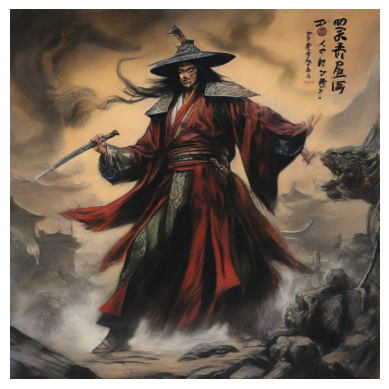

選項一: 龍傲天在戰鬥後發現師父被敵人擄走，他決定獨自踏上拯救之路。穿越陡峭的山巒和陰險的森林，龍傲天終於抵達敵人的藏身之地。他展開一場驚心動魄的單挑，最終成功解救師父，展現出他忠義仁勇的武俠精神。
選項二: 戰鬥結束後，龍傲天得知敵人背後竟是一個更加強大的黑暗勢力。為了守護武林和平，龍傲天踏上尋找黑暗勢力源頭的征途。在千難萬阻之中，他結識新朋友，共同面對重重考驗。最終，龍傲天與新夥伴攜手合作，打敗黑暗勢力，守護武林安寧。


KeyboardInterrupt: Interrupted by user

In [ ]:
from IPython.display import display, Javascript

# 定義一個函數來調整當前單元格的輸出文字大小
def set_output_text_size(size):
    display(Javascript(f"""
        var cell = document.querySelectorAll('.output_area pre');
        for (var i = 0; i < cell.length; i++) {{
            cell[i].style.fontSize = '{size}px';
        }}
    """))

# 使用這個函數來調整文字大小
set_output_text_size(100)  # 將文字大小設置為 100px



def run_story():
    user_name = input("請輸入您的姓名: ")

    #生成武俠角色
    character_info, img = generate_character(user_name)
    img.show()

    #生成幫派
    selected_clan = generate_clans(character_info)


    #生成武功
    selected_martial_arts = generate_martial_arts(selected_clan)
    # 清除當前單元格的輸出
    clear_output(wait=True)
    #生成故事情境
    conversation_history = generate_wuxia_story(character_info, selected_clan, selected_martial_arts, img)


    #生成结尾
    generate_conclusion(character_info, selected_clan, selected_martial_arts, conversation_history)



run_story()